In [47]:
import pandas as pd
import numpy as np
import joblib



In [48]:


# Load original full dataset with 'Pct_afro_american' and 'issue_date'
full_data = pd.read_csv("../data/dataproject2025.csv", parse_dates=['issue_d'])

# Filter for test period (2019-2020)
test_data = full_data[(full_data['issue_d'].dt.year >= 2019) & 
                             (full_data['issue_d'].dt.year <= 2020)]

protected_info = test_data[['Pct_afro_american']] 


In [49]:

dict_var = joblib.load("../models/needed_variables.pkl")
X_test = dict_var['X_test']
y_test = dict_var['y_test']
y_pred_test = dict_var['y_pred_test']
y_proba = dict_var['y_proba']

# Create dataframe for analysis
data = X_test.copy()
data['target'] = y_test
data['pred_prob'] = y_proba
data['pred_label'] = y_pred_test


In [50]:
# Add protected attribute

data['Pct_afro_american'] = protected_info['Pct_afro_american'].values


In [51]:
protected_col = 'Pct_afro_american'

# Median split
median_pct = data[protected_col].median()
data['group'] = np.where(data[protected_col] >= median_pct, 'high_afro', 'low_afro')

# Predicted Positive Rate (PPR)
ppr = data.groupby('group')['pred_prob'].mean()
spd = ppr['high_afro'] - ppr['low_afro']
di = ppr['high_afro'] / ppr['low_afro']

# TPR / TNR
tpr = data[data['target']==1].groupby('group')['pred_label'].mean()
tnr = data[data['target']==0].groupby('group')['pred_label'].apply(lambda x: (x==0).mean())

print("PPR by group:\n", ppr)
print("SPD:", spd)
print("DI:", di)
print("TPR by group:\n", tpr)
print("TNR by group:\n", tnr)


PPR by group:
 group
high_afro    0.391949
low_afro     0.378975
Name: pred_prob, dtype: float64
SPD: 0.012974690174163306
DI: 1.0342362969850827
TPR by group:
 group
high_afro    0.520544
low_afro     0.517162
Name: pred_label, dtype: float64
TNR by group:
 group
high_afro    0.754862
low_afro     0.772079
Name: pred_label, dtype: float64


In [52]:
test_data['target'] = y_test
test_data['pred_label'] = y_pred_test
test_data['pred_prob'] = y_proba

C:\Users\sheet\AppData\Local\Temp\ipykernel_33800\3931272184.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['target'] = y_test
C:\Users\sheet\AppData\Local\Temp\ipykernel_33800\3931272184.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['pred_label'] = y_pred_test
C:\Users\sheet\AppData\Local\Temp\ipykernel_33800\3931272184.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [53]:
def plot_fpdp(data, feature, protected_col='Pct_afro_american', n_bins=10):
    # Median split for fairness groups
    median_val = data[protected_col].median()
    data['group'] = np.where(data[protected_col] >= median_val, 'high_afro', 'low_afro')
    
    # Bin the feature using original values
    bins = np.linspace(data[feature].min(), data[feature].max(), n_bins+1)
    data['bin'] = pd.cut(data[feature], bins)
    
    # PDP: average predicted probability per bin
    pdp = data.groupby('bin')['pred_prob'].mean()
    
    # FPDP: mean predictions per group per bin
    bin_stats = data.groupby(['bin', 'group'])['pred_prob'].mean().unstack()
    bin_stats['fairness_diff'] = bin_stats['high_afro'] - bin_stats['low_afro']
    
    # Plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,6))
    plt.plot(pdp.index.astype(str), pdp.values, marker='o', label='PDP (overall)')
    plt.plot(bin_stats.index.astype(str), bin_stats['fairness_diff'], marker='x', label='Fairness diff (high - low)')
    plt.xticks(rotation=45)
    plt.ylabel("Predicted probability")
    plt.title(f"PDP + Fairness overlay for {feature}")
    plt.legend()
    plt.grid(True)
    plt.show()


C:\Users\sheet\AppData\Local\Temp\ipykernel_33800\3021960267.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['group'] = np.where(data[protected_col] >= median_val, 'high_afro', 'low_afro')
C:\Users\sheet\AppData\Local\Temp\ipykernel_33800\3021960267.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['bin'] = pd.cut(data[feature], bins)
C:\Users\sheet\AppData\Local\Temp\ipykernel_33800\3021960267.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a

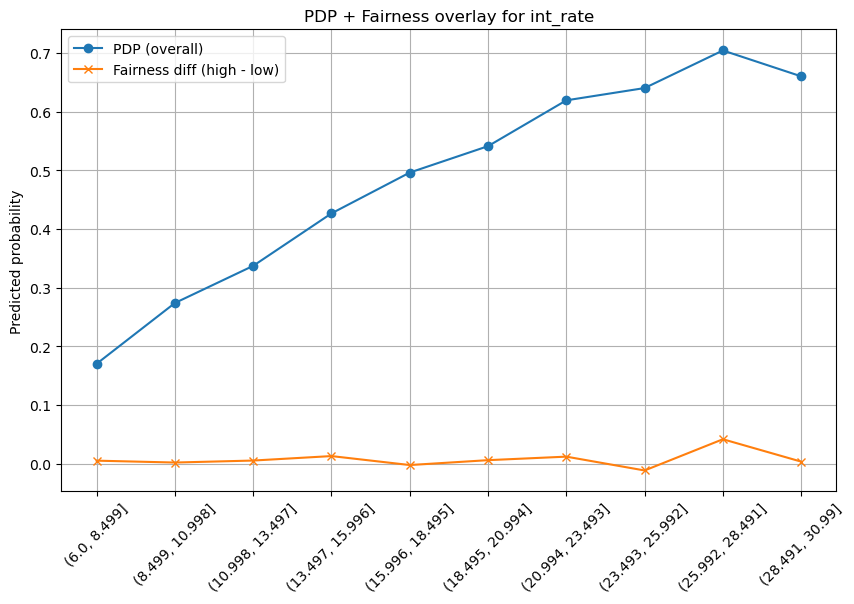

C:\Users\sheet\AppData\Local\Temp\ipykernel_33800\3021960267.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['group'] = np.where(data[protected_col] >= median_val, 'high_afro', 'low_afro')
C:\Users\sheet\AppData\Local\Temp\ipykernel_33800\3021960267.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['bin'] = pd.cut(data[feature], bins)
C:\Users\sheet\AppData\Local\Temp\ipykernel_33800\3021960267.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a

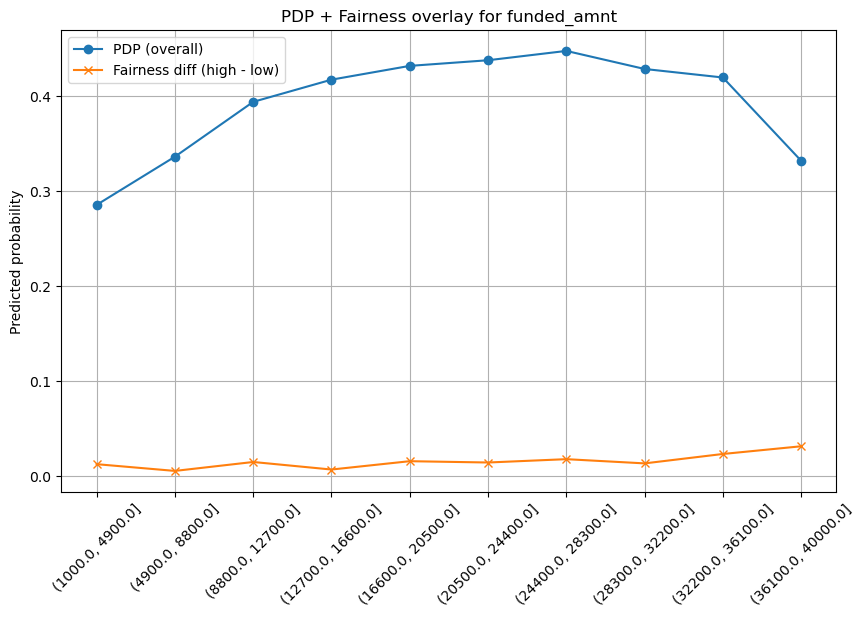

C:\Users\sheet\AppData\Local\Temp\ipykernel_33800\3021960267.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['group'] = np.where(data[protected_col] >= median_val, 'high_afro', 'low_afro')
C:\Users\sheet\AppData\Local\Temp\ipykernel_33800\3021960267.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['bin'] = pd.cut(data[feature], bins)
C:\Users\sheet\AppData\Local\Temp\ipykernel_33800\3021960267.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a

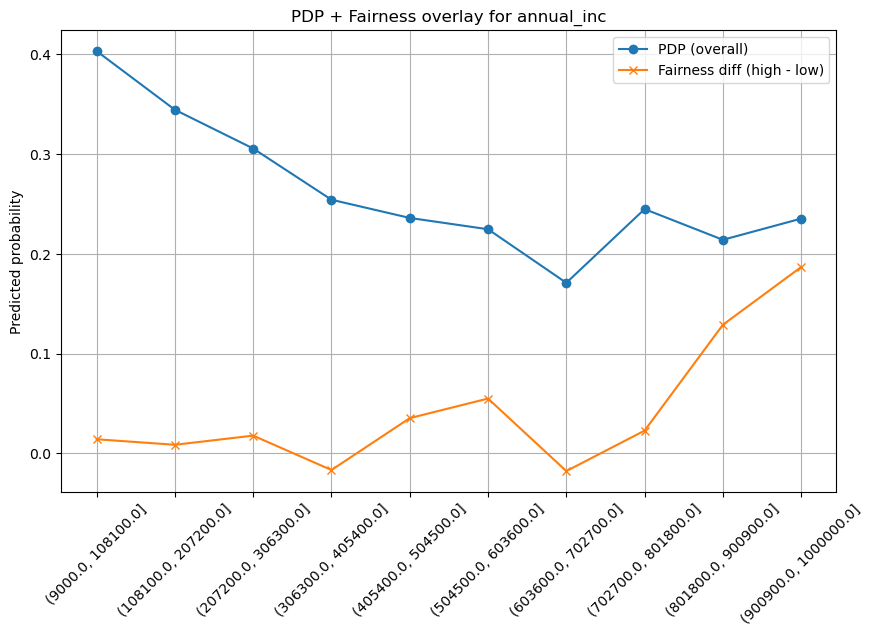

In [54]:
numeric_features = ['int_rate', 'funded_amnt', 'annual_inc']


for feature in numeric_features:
    plot_fpdp(test_data, feature)
